#Регрессия

##Базовая модель

Реализуем базовую модель градиентного бустинга GradientBoostingRegressor из sklearn на простом датасете: используются только агрегированные признаки чека TotalQuantity, NumLines и MeanPrice, без масштабирования, кодирования категориальных признаков и без обрезки выбросов.

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


DATA_DIR = Path("/content/drive/MyDrive/Учеба/Фреймворки/data")
SIMPLE_REG_PATH = DATA_DIR / "regression_data_simple.csv"

reg_simple = pd.read_csv(SIMPLE_REG_PATH)

print("Simple regression dataset shape:", reg_simple.shape)
print(reg_simple.head())

feature_cols = ["TotalQuantity", "NumLines", "MeanPrice"]
target_col = "TotalCheck"

X_s = reg_simple[feature_cols].values
y_s = reg_simple[target_col].values

print("\nFeature matrix shape (simple):", X_s.shape)
print("Target vector shape (simple):", y_s.shape)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_s,
    y_s,
    test_size=0.2,
    random_state=42,
)

print("\nTrain size (simple):", X_train_s.shape[0])
print("Test size (simple):", X_test_s.shape[0])

gbr_simple = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
)


gbr_simple.fit(X_train_s, y_train_s)
y_pred_gbr_s = gbr_simple.predict(X_test_s)

mae_gbr_s = mean_absolute_error(y_test_s, y_pred_gbr_s)
rmse_gbr_s = np.sqrt(mean_squared_error(y_test_s, y_pred_gbr_s))
r2_gbr_s = r2_score(y_test_s, y_pred_gbr_s)

print("\n=== 1) Sklearn GradientBoostingRegressor (simple baseline) ===")
print(f"MAE:  {mae_gbr_s:.2f}")
print(f"RMSE: {rmse_gbr_s:.2f}")
print(f"R²:   {r2_gbr_s:.4f}")


Simple regression dataset shape: (39574, 6)
   Invoice  CustomerID  TotalCheck  TotalQuantity  NumLines  MeanPrice
0   489434     13085.0      505.30            166         8   4.081250
1   489435     13085.0      145.80             60         4   2.625000
2   489436     13078.0      630.33            193        19   3.730526
3   489437     15362.0      310.75            145        23   3.628261
4   489438     18102.0     2286.24            826        17   2.591176

Feature matrix shape (simple): (39574, 3)
Target vector shape (simple): (39574,)

Train size (simple): 31659
Test size (simple): 7915

=== 1) Sklearn GradientBoostingRegressor (simple baseline) ===
MAE:  102.00
RMSE: 327.99
R²:   0.8914


Получили неплохие результаты, теперь попробуем добавить в модель ограничения на минимальный размер узлов (min_samples_split = 2, min_samples_leaf = 5)

In [ ]:
gbr_simple = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    min_samples_split=2,
    min_samples_leaf=5
)


gbr_simple.fit(X_train_s, y_train_s)
y_pred_gbr_s = gbr_simple.predict(X_test_s)

mae_gbr_s = mean_absolute_error(y_test_s, y_pred_gbr_s)
rmse_gbr_s = np.sqrt(mean_squared_error(y_test_s, y_pred_gbr_s))
r2_gbr_s = r2_score(y_test_s, y_pred_gbr_s)

print("\n=== 1) Sklearn GradientBoostingRegressor (simple baseline) ===")
print(f"MAE:  {mae_gbr_s:.2f}")
print(f"RMSE: {rmse_gbr_s:.2f}")
print(f"R²:   {r2_gbr_s:.4f}")


=== 1) Sklearn GradientBoostingRegressor (simple baseline) ===
MAE:  107.89
RMSE: 300.97
R²:   0.9085


Абсолютная ошибка MAE немного выросла, однако RMSE снизился, а R² заметно увеличился. Это означает, что модель стала лучше описывать крупные отклонения (уменьшились «тяжёлые» ошибки) и в целом точнее восстанавливать вариацию целевой переменной, при небольшой потере по средней абсолютной ошибке. В совокупности такая настройка выглядит более предпочтительной, если важнее качество модели в целом и контроль крупных ошибок, а не минимизация MAE любой ценой.

##Улучшенная модель

Далее реализуем GradientBoostingRegressor на улучшенном регрессионном датасете: используем расширенный набор признаков (агрегаты корзины, временные признаки, IsNewCustomer, qty_* по топ-товарам), предварительно обрезаем верхние 0.5% по TotalCheck, масштабируем числовые признаки и кодируем Country через One-Hot Encoding.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

HARD_REG_PATH = DATA_DIR / "regression_data_hard.csv"
target_col = "TotalCheck"

reg_imp = pd.read_csv(HARD_REG_PATH)

q_high = reg_imp[target_col].quantile(0.995)
mask = reg_imp[target_col] <= q_high
reg_trim = reg_imp[mask].reset_index(drop=True)

print("\nImproved regression dataset shape:", reg_imp.shape)
print("Trimmed rows:", len(reg_trim))
print("Cutoff (99.5% quantile) TotalCheck:", q_high)

exclude_cols = ["Invoice", "CustomerID", "InvoiceDate", target_col]
feature_cols_imp = [c for c in reg_trim.columns if c not in exclude_cols]

X_imp = reg_trim[feature_cols_imp]
y_imp = reg_trim[target_col].values

numeric_features = [c for c in feature_cols_imp if c != "Country"]
categorical_features = ["Country"] if "Country" in feature_cols_imp else []

transformers = []
if numeric_features:
    transformers.append(("num", StandardScaler(), numeric_features))
if categorical_features:
    transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features))

preprocessor = ColumnTransformer(transformers=transformers)

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_imp,
    y_imp,
    test_size=0.2,
    random_state=42,
)

print("\nImproved X shape:", X_imp.shape)
print("Improved y shape:", y_imp.shape)
print("Improved train size:", X_train_i.shape[0])
print("Improved test size:", X_test_i.shape[0])

gbr_improved = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", GradientBoostingRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            random_state=42,
        )),
    ]
)

gbr_improved.fit(X_train_i, y_train_i)
y_pred_gbr_i = gbr_improved.predict(X_test_i)

mae_gbr_i = mean_absolute_error(y_test_i, y_pred_gbr_i)
rmse_gbr_i = np.sqrt(mean_squared_error(y_test_i, y_pred_gbr_i))
r2_gbr_i = r2_score(y_test_i, y_pred_gbr_i)

print("\n=== 2) Sklearn GradientBoostingRegressor (improved baseline, trimmed + scaling + OHE) ===")
print(f"MAE:  {mae_gbr_i:.2f}")
print(f"RMSE: {rmse_gbr_i:.2f}")
print(f"R²:   {r2_gbr_i:.4f}")



Improved regression dataset shape: (39574, 113)
Trimmed rows: 39376
Cutoff (99.5% quantile) TotalCheck: 5739.156000000027

Improved X shape: (39376, 109)
Improved y shape: (39376,)
Improved train size: 31500
Improved test size: 7876

=== 2) Sklearn GradientBoostingRegressor (improved baseline, trimmed + scaling + OHE) ===
MAE:  83.21
RMSE: 179.16
R²:   0.8966


Для улучшенного набора признаков (агрегированные характеристики корзины, временные признаки, флаг нового покупателя, признаки по топ-товарам, стандартизация числовых столбцов, OHE для Country и обрезка выбросов по 99.5-перцентилю TotalCheck) модель GradientBoostingRegressor показала качество MAE ≈ 83.2, RMSE ≈ 179.2, R² ≈ 0.90 на тестовой выборке.
По сравнению с вариантами градиентного бустинга на простом бейзлайне, где использовались только агрегаты TotalQuantity, NumLines и MeanPrice, удалось заметно снизить ошибки (как MAE, так и RMSE) при сохранении высокой доли объяснённой дисперсии. Это показывает, что более информативный и аккуратно очищенный набор признаков позволяет бустингу эффективнее восстанавливать сумму чека.

Попробуем также добавить граничения на минимальный размер узлов

In [ ]:

gbr_improved = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", GradientBoostingRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            random_state=42,
            min_samples_split=2,
            min_samples_leaf=5
        )),
    ]
)

gbr_improved.fit(X_train_i, y_train_i)
y_pred_gbr_i = gbr_improved.predict(X_test_i)

mae_gbr_i = mean_absolute_error(y_test_i, y_pred_gbr_i)
rmse_gbr_i = np.sqrt(mean_squared_error(y_test_i, y_pred_gbr_i))
r2_gbr_i = r2_score(y_test_i, y_pred_gbr_i)

print("\n=== 2) Sklearn GradientBoostingRegressor (improved baseline, trimmed + scaling + OHE) ===")
print(f"MAE:  {mae_gbr_i:.2f}")
print(f"RMSE: {rmse_gbr_i:.2f}")
print(f"R²:   {r2_gbr_i:.4f}")


=== 2) Sklearn GradientBoostingRegressor (improved baseline, trimmed + scaling + OHE) ===
MAE:  83.40
RMSE: 180.66
R²:   0.8948


Добавление ограничений min_samples_split=2 и min_samples_leaf=5 к модели градиентного бустинга на улучшенном наборе признаков не привело к улучшению качества: MAE и RMSE немного выросли, а R² незначительно снизился. Это означает, что для данного варианта данных исходные настройки глубины и структуры деревьев оказываются более подходящими, и дополнительная «подкрутка» этих параметров не даёт выигрыша по метрикам.

Для повышения интерпретируемости моделей на основе деревьев решений дополнительно проведём анализ важности признаков. Для улучшенной модели Gradient boosting построем столбчатые диаграммы (bar plot) значений feature_importances_, на которых отображены ТОП-20 наиболее значимых признаков.

На графиках по оси X отложено значение важности признака, а по оси Y – его название (агрегированные характеристики корзины, временные признаки, индикатор IsNewCustomer, а также признаки формата qty_* и закодированная страна). По этим диаграммам можно увидеть, какие факторы вносят основной вклад в предсказание общей суммы чека и насколько стабильно одни и те же признаки оказываются важными для разных алгоритмов.

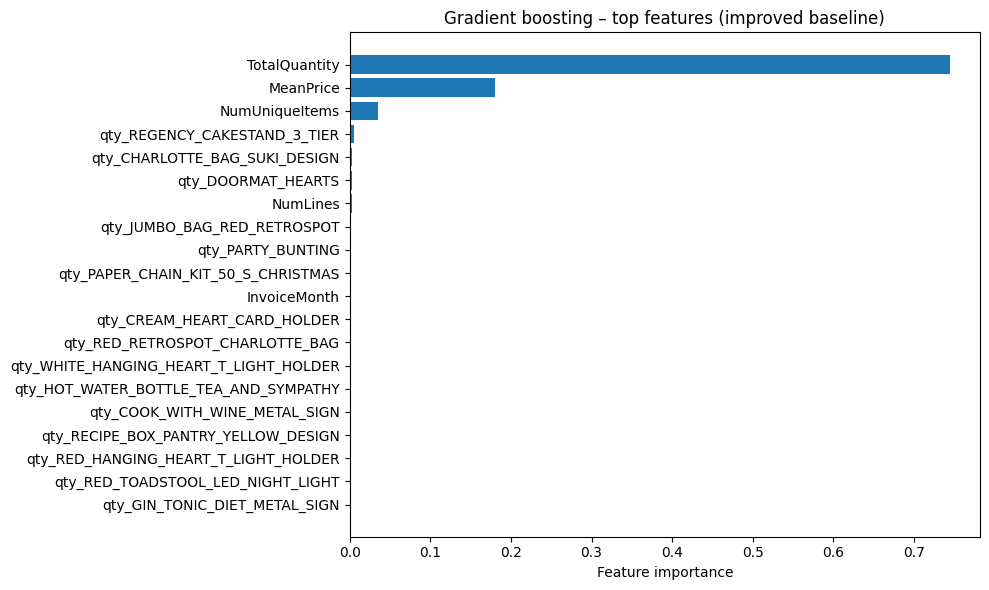

In [14]:
import numpy as np
import matplotlib.pyplot as plt

dt_model = gbr_improved

preprocessor = dt_model.named_steps["preprocess"]
tree = dt_model.named_steps["model"]

feature_names = []

if "num" in preprocessor.named_transformers_:
    feature_names.extend(numeric_features)

if "cat" in preprocessor.named_transformers_:
    ohe = preprocessor.named_transformers_["cat"]
    cat_names = list(ohe.get_feature_names_out(categorical_features))
    feature_names.extend(cat_names)

importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 20
top_idx = indices[:top_n]

plt.figure(figsize=(10, 6))
plt.barh(
    np.array(feature_names)[top_idx][::-1],
    importances[top_idx][::-1],
)
plt.xlabel("Feature importance")
plt.title("Gradient boosting – top features (improved baseline)")
plt.tight_layout()
plt.show()


Анализ диаграммы важности признаков для модели Gradient Boosting на улучшенном бейзлайне показывает, что решающую роль в предсказании суммы чека играют агрегированные характеристики корзины.

TotalQuantity (общее количество единиц товара в чеке) является доминирующим признаком и даёт основной вклад в качество модели.

На втором месте находится MeanPrice (средняя цена позиции в чеке), что отражает зависимости суммы покупки не только от размера корзины, но и от общего уровня цен приобретённых товаров.

Дополнительный вклад вносит признак NumUniqueItems, характеризующий разнообразие товаров в корзине.

Индивидуальные признаки формата qty_* (количество конкретных популярных товаров) имеют заметно меньшую важность: они скорее уточняют предсказания для отдельных сценариев, чем определяют общую структуру модели.

Таким образом, модель подтверждает интуитивно ожидаемую картину: основными факторами, определяющими сумму чека, являются размер корзины и уровень цен, а информация о конкретных товарах и более тонкие характеристики корзины играют вспомогательную роль.

##Имплементирование алгоритма

###Базовая модель

Реализуем кастомную модель MyGradientBoostingRegressor, которая последовательно обучает несколько наших же MyDecisionTreeRegressor, каждый раз аппроксимируя остатки предыдущей композиции. Обучаем её на том же простом бейзлайне (TotalQuantity, NumLines, MeanPrice), без масштабирования и без работы с категориальными признаками, и сравниваем метрики с библиотечной реализацией градиентного бустинга.

In [ ]:
class MyDecisionTreeRegressor:
    class Node:
        def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
            self.feature_idx = feature_idx
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    def __init__(self, max_depth=8, min_samples_split=50, min_samples_leaf=20):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.root_ = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        self.root_ = self._build_tree(X, y, depth=0)
        return self

    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape

        if n_samples == 0:
            return self.Node(value=0.0)

        if depth >= self.max_depth or n_samples < self.min_samples_split or np.allclose(y, y[0]):
            value = float(y.mean())
            return self.Node(value=value)

        best_feature, best_threshold, best_loss = self._find_best_split(X, y)

        if best_feature is None:
            value = float(y.mean())
            return self.Node(value=value)

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]

        if X_left.shape[0] == 0 or X_right.shape[0] == 0:
            value = float(y.mean())
            return self.Node(value=value)

        left_child = self._build_tree(X_left, y_left, depth + 1)
        right_child = self._build_tree(X_right, y_right, depth + 1)

        return self.Node(
            feature_idx=best_feature,
            threshold=best_threshold,
            left=left_child,
            right=right_child,
            value=None,
        )

    def _find_best_split(self, X, y):
        n_samples, n_features = X.shape
        if n_samples < 2 * self.min_samples_leaf:
            return None, None, None

        total_sum = y.sum()
        total_sq_sum = np.dot(y, y)

        best_feature = None
        best_threshold = None
        best_loss = np.inf

        for j in range(n_features):
            xj = X[:, j]
            order = np.argsort(xj)
            xj_sorted = xj[order]
            y_sorted = y[order]

            y_cumsum = np.cumsum(y_sorted)
            y_sq_cumsum = np.cumsum(y_sorted ** 2)

            for i in range(1, n_samples):
                if xj_sorted[i] == xj_sorted[i - 1]:
                    continue

                n_left = i
                n_right = n_samples - i
                if n_left < self.min_samples_leaf or n_right < self.min_samples_leaf:
                    continue

                sum_left = y_cumsum[i - 1]
                sq_left = y_sq_cumsum[i - 1]
                sum_right = total_sum - sum_left
                sq_right = total_sq_sum - sq_left

                sse_left = sq_left - (sum_left ** 2) / n_left
                sse_right = sq_right - (sum_right ** 2) / n_right
                loss = sse_left + sse_right

                if loss < best_loss:
                    best_loss = loss
                    best_feature = j
                    best_threshold = 0.5 * (xj_sorted[i - 1] + xj_sorted[i])

        return best_feature, best_threshold, best_loss

    def _predict_one(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_idx] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    def predict(self, X):
        if self.root_ is None:
            raise RuntimeError("You must call fit() before predict().")
        X = np.asarray(X, dtype=float)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        preds = [self._predict_one(x, self.root_) for x in X]
        return np.array(preds)


class MyGradientBoostingRegressor:
    def __init__(
        self,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=None,
    ):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.init_ = None
        self.trees_ = []

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)

        self.init_ = float(y.mean())
        residual = y - self.init_
        self.trees_ = []

        for m in range(self.n_estimators):
            tree = MyDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
            )
            tree.fit(X, residual)
            self.trees_.append(tree)

            pred = tree.predict(X)
            residual = residual - self.learning_rate * pred

        return self

    def predict(self, X):
        if self.init_ is None or not self.trees_:
            raise RuntimeError("You must call fit() before predict().")

        X = np.asarray(X, dtype=float)
        if X.ndim == 1:
            X = X.reshape(1, -1)

        y_pred = np.full(X.shape[0], self.init_, dtype=float)
        for tree in self.trees_:
            y_pred += self.learning_rate * tree.predict(X)

        return y_pred


my_gbr_simple = MyGradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=5,
    random_state=42,
)

my_gbr_simple.fit(X_train_s, y_train_s)
y_pred_my_gbr_s = my_gbr_simple.predict(X_test_s)

mae_my_gbr_s = mean_absolute_error(y_test_s, y_pred_my_gbr_s)
rmse_my_gbr_s = np.sqrt(mean_squared_error(y_test_s, y_pred_my_gbr_s))
r2_my_gbr_s = r2_score(y_test_s, y_pred_my_gbr_s)

print("\n=== 3) Custom GradientBoostingRegressor (simple baseline) ===")
print(f"MAE:  {mae_my_gbr_s:.2f}")
print(f"RMSE: {rmse_my_gbr_s:.2f}")
print(f"R²:   {r2_my_gbr_s:.4f}")



=== 3) Custom GradientBoostingRegressor (simple baseline) ===
MAE:  108.86
RMSE: 302.92
R²:   0.9073


На базовом наборе признаков (TotalQuantity, NumLines, MeanPrice) была реализована кастомная модель градиентного бустинга на основе кастомных деревьев решений. Полученные метрики MAE ≈ 108.9, RMSE ≈ 302.9, R² ≈ 0.91 сопоставимы с результатами библиотечной реализации GradientBoostingRegressor на тех же данных.
Это показывает, что кастомная реализация корректно воспроизводит логику градиентного бустинга и способна достигать близкого качества, хотя при этом не использует оптимизации и параллелизм, характерные для реализации из sklearn.

###Улучшенная модель

Обучим модель MyGradientBoostingRegressor на улучшенном датасете: перед обучением выполняется тот же препроцессинг, что и для sklearn-модели (обрезка по 99.5-перцентилю TotalCheck, масштабирование числовых признаков, one-hot кодирование Country), после чего уже готовая числовая матрица признаков подаётся в кастомный бустинг. По метрикам и поведению проверяем, насколько результаты согласуются с библиотечной реализацией.

In [ ]:
reg_imp = pd.read_csv(HARD_REG_PATH)

q_high = reg_imp[target_col].quantile(0.995)
mask = reg_imp[target_col] <= q_high
reg_trim = reg_imp[mask].reset_index(drop=True)

exclude_cols = ["Invoice", "CustomerID", "InvoiceDate", target_col]
feature_cols_imp = [c for c in reg_trim.columns if c not in exclude_cols]

X_imp = reg_trim[feature_cols_imp]
y_imp = reg_trim[target_col].values

numeric_features = [c for c in feature_cols_imp if c != "Country"]
categorical_features = ["Country"] if "Country" in feature_cols_imp else []

transformers = []
if numeric_features:
    transformers.append(("num", StandardScaler(), numeric_features))
if categorical_features:
    transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features))

preprocessor_gb = ColumnTransformer(transformers=transformers)

X_train_i2, X_test_i2, y_train_i2, y_test_i2 = train_test_split(
    X_imp,
    y_imp,
    test_size=0.2,
    random_state=42,
)

X_train_imp_proc = preprocessor_gb.fit_transform(X_train_i2)
X_test_imp_proc = preprocessor_gb.transform(X_test_i2)

print("Processed improved train shape:", X_train_imp_proc.shape)
print("Processed improved test shape:", X_test_imp_proc.shape)

my_gbr_improved = MyGradientBoostingRegressor(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=3,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
)

my_gbr_improved.fit(X_train_imp_proc, y_train_i2)
y_pred_my_gbr_i = my_gbr_improved.predict(X_test_imp_proc)

mae_my_gbr_i = mean_absolute_error(y_test_i2, y_pred_my_gbr_i)
rmse_my_gbr_i = np.sqrt(mean_squared_error(y_test_i2, y_pred_my_gbr_i))
r2_my_gbr_i = r2_score(y_test_i2, y_pred_my_gbr_i)

print("\n=== 4) Custom GradientBoostingRegressor (improved baseline, trimmed + scaling + OHE) ===")
print(f"MAE:  {mae_my_gbr_i:.2f}")
print(f"RMSE: {rmse_my_gbr_i:.2f}")
print(f"R²:   {r2_my_gbr_i:.4f}")


Processed improved train shape: (31500, 151)
Processed improved test shape: (7876, 151)

=== 4) Custom GradientBoostingRegressor (improved baseline, trimmed + scaling + OHE) ===
MAE:  90.23
RMSE: 187.27
R²:   0.8870


Для улучшенного набора признаков (агрегаты корзины, временные признаки, IsNewCustomer, qty_*, масштабирование числовых признаков и OHE для Country с обрезкой выбросов по 99.5-перцентилю TotalCheck) кастомная реализация градиентного бустинга с параметрами n_estimators=150, learning_rate=0.05, max_depth=3, min_samples_split=5, min_samples_leaf=2, random_state=42 показала качество MAE ≈ 90.2, RMSE ≈ 187.3, R² ≈ 0.887. Результат немного уступает библиотечной модели GradientBoostingRegressor на тех же данных, но остаётся близким по всем метрикам, что подтверждает корректность реализации алгоритма. Разница в качестве и скорости объясняется отсутствием в кастомном варианте низкоуровневых оптимизаций и параллелизма.

#Классификация

##Базовая модель

##Улучшенная модель

##Имплементирование алгоритма

###Базовая модель

###Улучшенная модель